# Predicting Diabetes - Random Forest

## Import modules

In [1]:
import os
import numpy as np
import pandas as pd
import time
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

## Data preparation

In [2]:
dir_data = "../data"
path_data = os.path.join(dir_data, "diabetes_data.csv")
df = pd.read_csv(path_data)

#### To select a subset of features from correlation matrix 

In [3]:
ldf = df[["Age", "HighChol", "GenHlth", "MentHlth", "PhysHlth", "DiffWalk", "HighBP", "Diabetes"]] 

#### To select a small subset from the whole datasets for test ML run

In [4]:
random_state = 42
ldf_sample = ldf.sample(n=3000)
X = ldf_sample.drop(columns=["Diabetes"])
Y = ldf_sample[["Diabetes"]]

## Random Forest

In [5]:
def run_rf(X, Y, test_size = 0.3, random_state=42, n_estimators=100, max_depth=3, max_features=2, criterion='gini'):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = test_size, random_state = random_state)
    model = RandomForestClassifier(random_state=random_state, n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)
    model.fit(x_train, y_train)
    mean_accuracy = model.score(x_test, y_test) # 1 - mean_absolute_error
    return mean_accuracy

#### Hyperparameter optimization 

In [6]:
max_mean_accuracy = 0
min_mean_accuracy = 1

max_hyperpara = {}
min_hyperpara = {}

starting_time = time.time()
for nbr_est in np.arange(10, 150, 10):
    for depth in range(1, 10, 1):
        for ts in np.arange(0.2, 0.7, 0.1): 
            for nbr_features in np.arange(1, 4, 1):
                mean_accuracy = run_rf(X, Y, test_size=ts, n_estimators=nbr_est, max_depth=depth, max_features=nbr_features)
                if mean_accuracy < min_mean_accuracy:
                    min_mean_accuracy = mean_accuracy
                    min_hyperpara["n_estimators"] = nbr_est
                    min_hyperpara["max_depth"] = depth
                    min_hyperpara["test_size"] = ts
                    min_hyperpara["max_features"] = nbr_features
                if mean_accuracy > max_mean_accuracy:
                    max_mean_accuracy = mean_accuracy
                    max_hyperpara["n_estimators"] = nbr_est
                    max_hyperpara["max_depth"] = depth
                    max_hyperpara["test_size"] = ts
                    max_hyperpara["max_features"] = nbr_features
                                         
ending_time = time.time()

print("time:", ending_time - starting_time, "max:", max_mean_accuracy, "min:", min_mean_accuracy, "range:", max_mean_accuracy - min_mean_accuracy)
print(max_hyperpara)
print(min_hyperpara)

#### K-fold cross validation

In [7]:
X_kfold = X.copy()
X_kfold["kFold"] = -1

nbr_fold = 5
kf = KFold(n_splits=nbr_fold, shuffle=True, random_state=42)

cross_validation = dict()
expected_mean_accuracy = 0
for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X_kfold)):
    X_train = X_kfold.iloc[train_indicies,:]
    X_valid = X_kfold.iloc[valid_indicies,:]
    Y_train = Y.iloc[train_indicies,:]
    Y_valid = Y.iloc[valid_indicies,:]
    model = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=8, max_features=2)
    model.fit(X_train, Y_train)
    mean_accuracy = model.score(X_valid, Y_valid) # 1 - mean_absolute_error
    expected_mean_accuracy += mean_accuracy
    print(fold, mean_accuracy)
    
expected_mean_accuracy = expected_mean_accuracy / nbr_fold
print("expected_mean_accuracy:", expected_mean_accuracy)

0 0.7383333333333333
1 0.7383333333333333
2 0.7466666666666667
3 0.75
4 0.745
expected_mean_accuracy: 0.7436666666666667


#### Early stopping approximated by min-impurity_decrease 

In [8]:
## USE the cross_val in scikit learn 

max_expected_mean_accuracy = 0
impurity_for_max_accuracy = 0 
for impurity in np.arange(0, 0.1, 0.01):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cross_validation = dict()
    expected_mean_accuracy = 0
    for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X_kfold)):
        X_train = X_kfold.iloc[train_indicies,:]
        X_valid = X_kfold.iloc[valid_indicies,:]
        Y_train = Y.iloc[train_indicies,:]
        Y_valid = Y.iloc[valid_indicies,:]
        model = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=8, max_features=2, min_impurity_decrease=impurity)
        model.fit(X_train, Y_train)
        mean_accuracy = model.score(X_valid, Y_valid) # 1 - mean_absolute_error
        expected_mean_accuracy += mean_accuracy

    expected_mean_accuracy = expected_mean_accuracy / 5
    print("impurity:", impurity, "expected_mean_accuracy:", expected_mean_accuracy)
    if expected_mean_accuracy > max_expected_mean_accuracy:
        max_expected_mean_accuracy = expected_mean_accuracy
        impurity_for_max_accuracy = impurity

print("impurity_for_max_accuracy:", impurity_for_max_accuracy, "max_expected_mean_accuracy:", max_expected_mean_accuracy)

impurity: 0.0 expected_mean_accuracy: 0.7436666666666667
impurity: 0.01 expected_mean_accuracy: 0.7263333333333334
impurity: 0.02 expected_mean_accuracy: 0.7156666666666667
impurity: 0.03 expected_mean_accuracy: 0.7130000000000001
impurity: 0.04 expected_mean_accuracy: 0.7103333333333334
impurity: 0.05 expected_mean_accuracy: 0.7086666666666667
impurity: 0.06 expected_mean_accuracy: 0.7086666666666667
impurity: 0.07 expected_mean_accuracy: 0.7006666666666667
impurity: 0.08 expected_mean_accuracy: 0.6463333333333334
impurity: 0.09 expected_mean_accuracy: 0.5680000000000001
impurity_for_max_accuracy: 0.0 max_expected_mean_accuracy: 0.7436666666666667


In [9]:
max_expected_mean_accuracy = 0
impurity_for_max_accuracy = 0 
for impurity in np.arange(0, 0.1, 0.01):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cross_validation = dict()
    expected_mean_accuracy = 0
    for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X_kfold)):
        X_train = X_kfold.iloc[train_indicies,:]
        X_valid = X_kfold.iloc[valid_indicies,:]
        Y_train = Y.iloc[train_indicies,:]
        Y_valid = Y.iloc[valid_indicies,:]
        model = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=5, max_features=2, min_impurity_decrease=impurity)
        model.fit(X_train, Y_train)
        mean_accuracy = model.score(X_valid, Y_valid) # 1 - mean_absolute_error
        expected_mean_accuracy += mean_accuracy

    expected_mean_accuracy = expected_mean_accuracy / 5
    print("impurity:", impurity, "expected_mean_accuracy:", expected_mean_accuracy)
    if expected_mean_accuracy > max_expected_mean_accuracy:
        max_expected_mean_accuracy = expected_mean_accuracy
        impurity_for_max_accuracy = impurity

print("impurity_for_max_accuracy:", impurity_for_max_accuracy, "max_expected_mean_accuracy:", max_expected_mean_accuracy)

impurity: 0.0 expected_mean_accuracy: 0.744
impurity: 0.01 expected_mean_accuracy: 0.7263333333333334
impurity: 0.02 expected_mean_accuracy: 0.7156666666666667
impurity: 0.03 expected_mean_accuracy: 0.7130000000000001
impurity: 0.04 expected_mean_accuracy: 0.7103333333333334
impurity: 0.05 expected_mean_accuracy: 0.7086666666666667
impurity: 0.06 expected_mean_accuracy: 0.7086666666666667
impurity: 0.07 expected_mean_accuracy: 0.7006666666666667
impurity: 0.08 expected_mean_accuracy: 0.6463333333333334
impurity: 0.09 expected_mean_accuracy: 0.5680000000000001
impurity_for_max_accuracy: 0.0 max_expected_mean_accuracy: 0.744


## SHAP analysis

#### Build SHAP explainer 

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = random_state)
model = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=8, max_features=2)
model.fit(x_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)

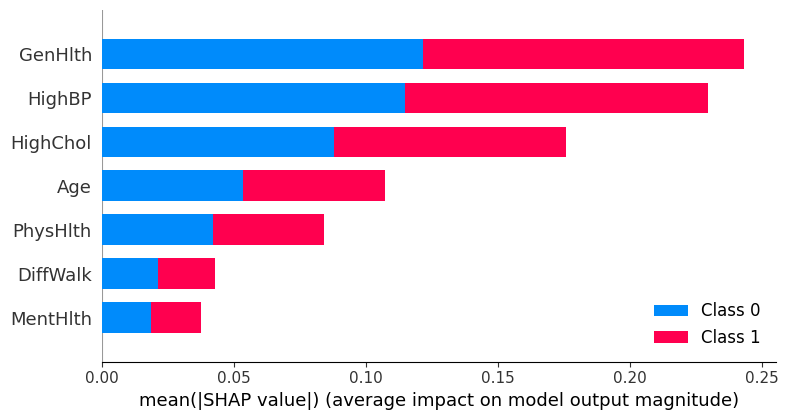

In [11]:
shap.summary_plot(shap_values, x_test, plot_type="bar")

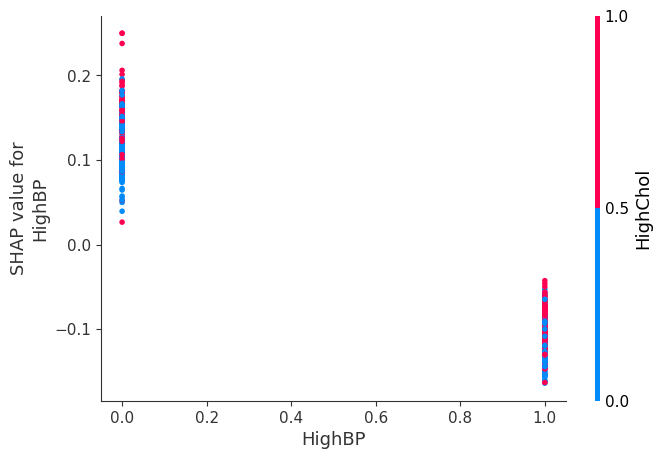

In [12]:
shap.dependence_plot("HighBP", shap_values[0], x_test)

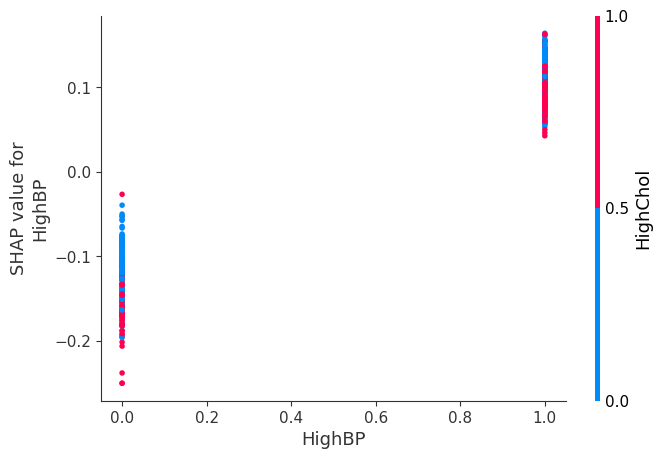

In [13]:
shap.dependence_plot("HighBP", shap_values[1], x_test)

0


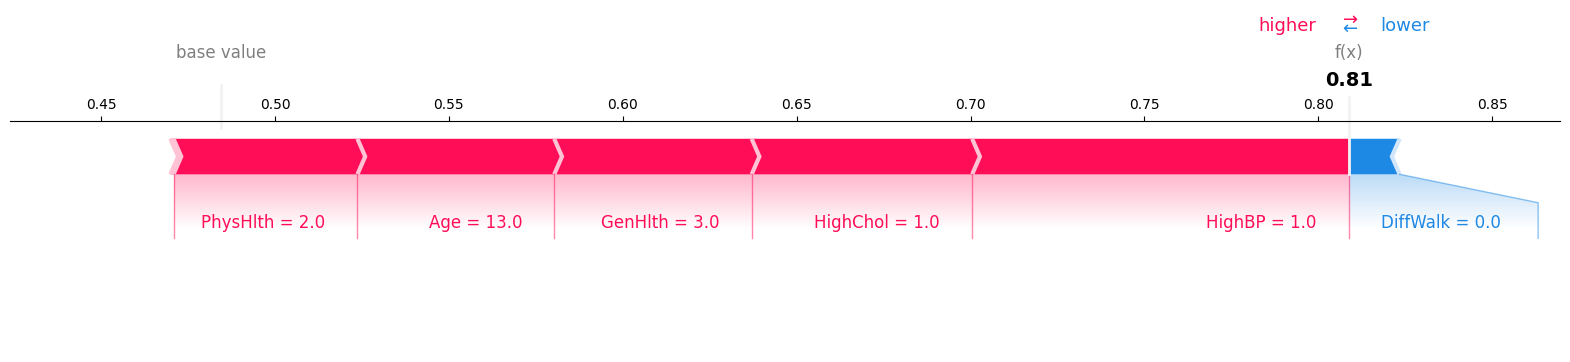

200


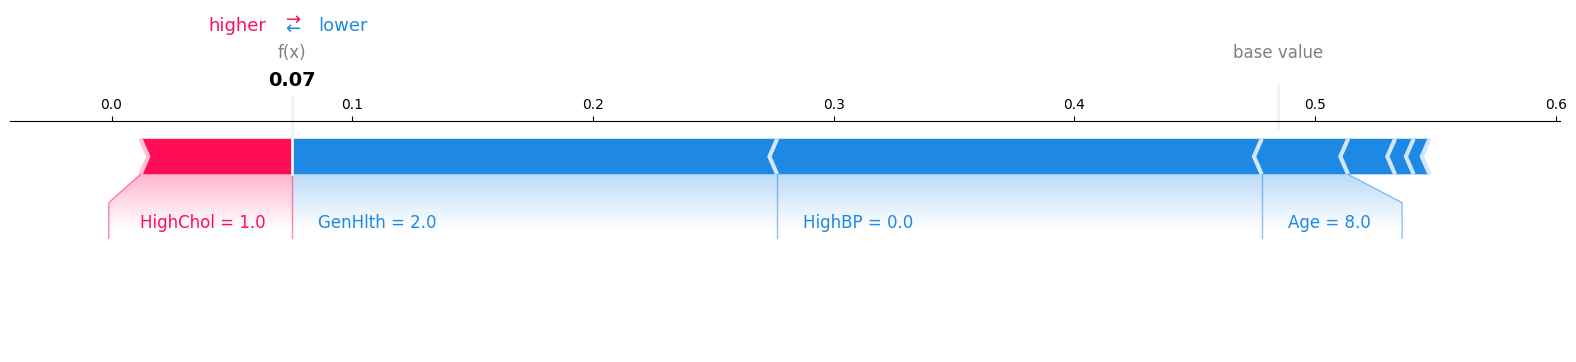

400


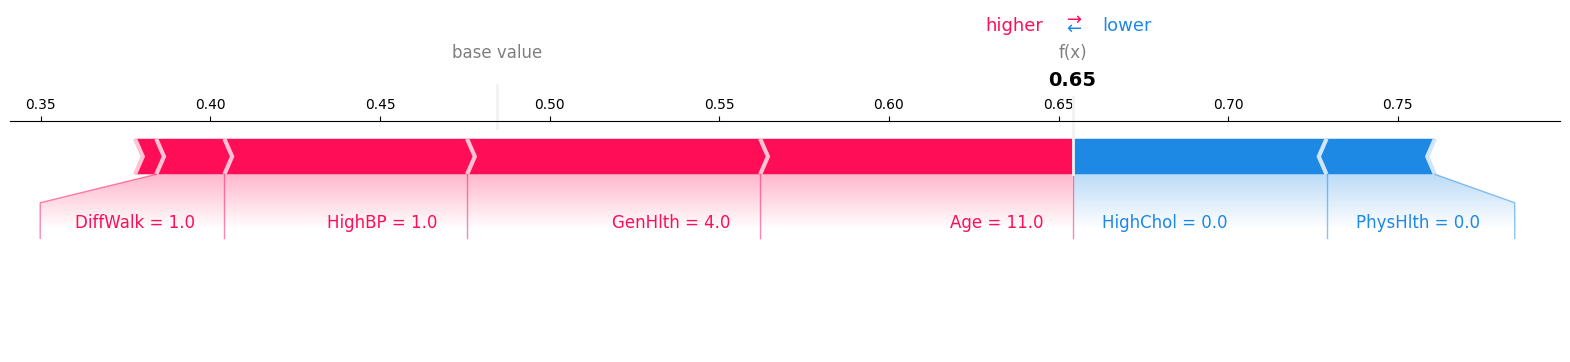

In [14]:
for i in np.arange(0, 600, 200):
    print(i)
    instance = x_test.iloc[[i]]
    shap_values = explainer.shap_values(instance)
    shap.force_plot(explainer.expected_value[1], shap_values[1],instance, matplotlib=True)